<a href="https://colab.research.google.com/github/ai4ci-kpi/Federated-Learning/blob/main/MedNIST__Federated_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

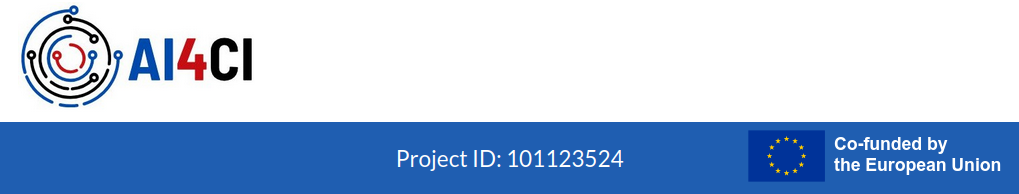

# Environment setup

To start using **Flower** just activate your Python environment (e.g., conda virtualenv). On Colab, simply install Flower and any extra dependencies.

## Installing Flower 🌼
You can easily install Flower using pip (please restart this command to resolve the error issue):

In [1]:
!pip install -q "flwr[simulation]" flwr-datasets

We’ll use Flower’s Simulation Engine, which efficiently runs many clients without manual device management, making large-scale simulations easy and scalable.

Flower is agnostic to your choice of ML Framework. Flower works with PyTorch, Tensorflow, NumPy, Transformers, MLX, JAX, scikit-learn, fastai, Pandas. It also works across major platforms like iOS, Android and plain C++.

# Preparing and loading the Dataset

The [MedNIST dataset](https://medmnist.com/) combines images from [TCIA](https://wiki.cancerimagingarchive.net/display/Public/Data+Usage+Policies+and+Restrictions), [the RSNA Bone Age Challenge](http://rsnachallenges.cloudapp.net/competitions/4), and [the NIH Chest X-ray dataset](https://cloud.google.com/healthcare/docs/resources/public-datasets/nih-chest).


The MedMNIST dataset is licensed under Creative Commons Attribution 4.0 International (CC BY 4.0), except DermaMNIST under Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0).


In [2]:
!pip install medmnist

In [3]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, transforms
from torch.utils.data import random_split


import medmnist
from medmnist import INFO, Evaluator

In [4]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [5]:
data_flag = 'chestmnist'

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [6]:
info

{'python_class': 'ChestMNIST',
 'description': 'The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.',
 'url': 'https://zenodo.org/records/10519652/files/chestmnist.npz?download=1',
 'MD5': '02c8a6516a18b556561a56cbdd36c4a8',
 'url_64': 'https://zenodo.org/records/10519652/files/chestmnist_64.npz?download=1',
 'MD5_64': '9de6cd0b934ebb5b7426cfba5efbae16',
 'url_128': 'https://zenodo.org/records/10519652/files/chestmnist_128.npz?download=1',
 'MD5_128': 'db107e5590b27930b62dbaf558aebee3',
 'url_224': 'https://zenodo.org/records/10519652/files/chestmnist_224.npz?download=1',
 'MD5_224': '45bd33e6f06c3e8cdb481c74a89152aa',
 'task': 'multi-label, binary-class',
 'label': {'0': 'atelectasis',
  '1': 'cardi

In [7]:
n_channels

1

In [8]:
n_classes

14

In [9]:
# Setup
BATCH_SIZE = 32
IMAGE_SIZE = 128
USE_AMP = True  # Mixed precision

TASK = "multi-label, binary-class"
DOWNLOAD = True

In [10]:
# Data transformations
data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Data downloading (assuming the DataClass is already defined). The following commands download the dataset (~1.43GB).
train_dataset = DataClass(split='train', transform=data_transform, download=DOWNLOAD, size=IMAGE_SIZE)
val_dataset = DataClass(split='val', transform=data_transform, download=DOWNLOAD, size=IMAGE_SIZE)
test_dataset = DataClass(split='test', transform=data_transform, download=DOWNLOAD, size=IMAGE_SIZE)


train_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = data.DataLoader(test_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
val_loader = data.DataLoader(val_dataset, batch_size=2*BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [11]:
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset ChestMNIST of size 128 (chestmnist_128)
    Number of datapoints: 78468
    Root location: C:\Users\GZ\.medmnist
    Split: train
    Task: multi-label, binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'atelectasis', '1': 'cardiomegaly', '2': 'effusion', '3': 'infiltration', '4': 'mass', '5': 'nodule', '6': 'pneumonia', '7': 'pneumothorax', '8': 'consolidation', '9': 'edema', '10': 'emphysema', '11': 'fibrosis', '12': 'pleural', '13': 'hernia'}
    Number of samples: {'train': 78468, 'val': 11219, 'test': 22433}
    Description: The ChestMNIST is based on the NIH-ChestXray14 dataset, a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1×1024×1024 into 1×28×28.
    License: CC BY 4.0
Dataset ChestMNIST of size 128 (chestmnist_128)
    Number of datapoints

## Visualise some examples from the dataset

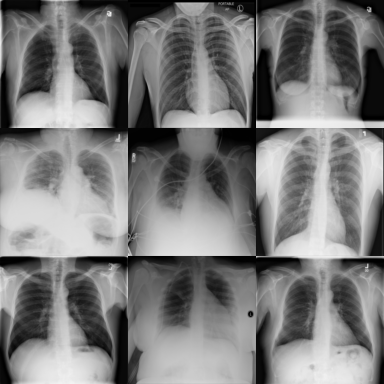

In [12]:
train_dataset.montage(length=3)

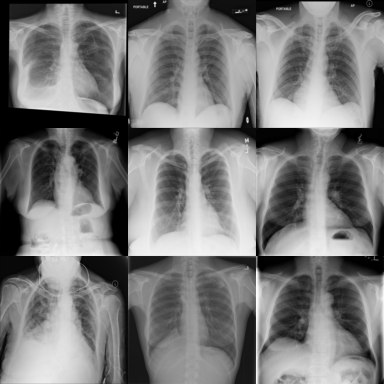

In [13]:
val_dataset.montage(length=3)

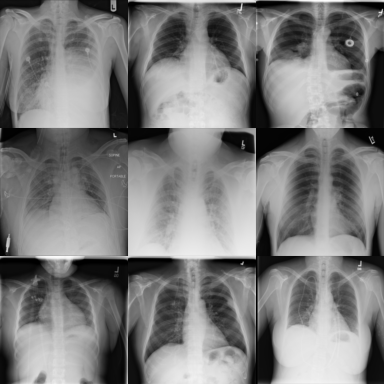

In [14]:
test_dataset.montage(length=3)

In [15]:
train_dataset[5]

(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -0.9373, -0.9529, -0.9608],
          [-1.0000, -1.0000, -1.0000,  ..., -0.8745, -0.8510, -0.8353],
          [-1.0000, -1.0000, -1.0000,  ..., -0.6078, -0.5529, -0.6784],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -0.9294, -0.9294, -0.9216],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9294, -0.9294, -0.9216],
          [-1.0000, -1.0000, -1.0000,  ..., -0.9373, -0.9373, -0.9373]]]),
 array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]))

## Define network and optimizer

In [16]:
def create_model():
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # ChestMNIST n_channels = 1
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 14),  # n_classes = 14
        nn.Sigmoid()  # multi-label
    )
    return model

In [17]:
model = create_model()
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 11187042


In [18]:
criterion = nn.BCELoss()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, trainloader, optimizer,  device="cuda"):
    """Train the model on the training set."""
    model.train()
    model.to(device)
    total_loss = 0.0

    for images, labels in tqdm(trainloader, desc="Training", leave=False):
        images, labels = images.to(device), labels.float().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)

    avg_loss = total_loss / len(trainloader.dataset)
    return avg_loss

def test(model, testloader):
    """Evaluate the model on the test set."""
    model.eval()
    model.to(DEVICE)
    total_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="Evaluating", leave=False):
            images, labels = images.to(DEVICE), labels.float().to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)

            preds = (outputs > 0.5).int().cpu()
            y_pred.extend(preds)
            y_true.extend(labels.cpu().int())

    y_pred = torch.stack(y_pred)
    y_true = torch.stack(y_true)
    acc = (y_pred == y_true).sum().item() / y_true.numel()
    avg_loss = total_loss / len(testloader.dataset)
    return avg_loss, acc


def run_centralised(trainloader, testloader, epochs: int, lr: float, momentum: float = 0.9):
    """A minimal (but complete) training loop"""
    model = create_model()

    # Discover device
    print(torch.cuda.is_available())
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        train_loss = train(model, trainloader, optimizer, device=device)
        print(f"Train loss: {train_loss:.4f}")

    test_loss, test_acc = test(model, testloader)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_acc:.4f}")

In [19]:
# Run the centralised training
run_centralised(train_loader, test_loader, epochs=3, lr=0.01)

True
cuda:0
Epoch 1/3


Train loss: 0.1758
Epoch 2/3


Train loss: 0.1686
Epoch 3/3


Train loss: 0.1647


Test loss: 0.1688
Test accuracy: 0.9476


#  Federated Learning



*  Federated Learning is distributed -- the model is trained on-device by the participating clients.
    
*  Data remains private and is owned by a specific client -- the data is never sent to the central server.



## One Client, One Data Partition

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To accomplish this with the ChestMNIST dataset, we are going to generate N random partitions, where N is the total number of clients in our FL system. Let's create 10 partitions with the [IidPartitioner](https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.IidPartitioner.html#flwr_datasets.partitioner.IidPartitioner) -- note there are many more [partitioners](https://flower.ai/docs/datasets/ref-api/flwr_datasets.partitioner.html) to choose from.

In [20]:
# Number of partitions
NUM_PARTITIONS = 10

# Number of elements per partition
part_len = len(train_dataset) // NUM_PARTITIONS

# Check for remainder
remainder = len(train_dataset) % NUM_PARTITIONS

# If there is a remainder, distribute the extra elements evenly
part_lengths = [part_len] * NUM_PARTITIONS

# If there is a remainder, add 1 extra element to the first few partitions
for i in range(remainder):
    part_lengths[i] += 1

# Split into subsets
fds = random_split(train_dataset, part_lengths)

# Check the number of elements in each subset
print(f"Number of elements in each partition dataset:")
for i, part_data in enumerate(fds):
    print(f"Partition {i}: {len(part_data)} samples")

Number of elements in each partition dataset:
Partition 0: 7847 samples
Partition 1: 7847 samples
Partition 2: 7847 samples
Partition 3: 7847 samples
Partition 4: 7847 samples
Partition 5: 7847 samples
Partition 6: 7847 samples
Partition 7: 7847 samples
Partition 8: 7846 samples
Partition 9: 7846 samples


In [21]:
# We could load a single partition like this
partition_0 = fds[0]
partition_0

In [22]:
partition_0[0]

(tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-0.7804, -0.7725, -0.7882,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7725, -0.7725, -0.7882,  ..., -1.0000, -1.0000, -1.0000],
          [-0.7804, -0.7804, -0.7961,  ..., -1.0000, -1.0000, -1.0000]]]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

# Visualization of the partitioned datasets

Label distribution of the partitioned dataset.

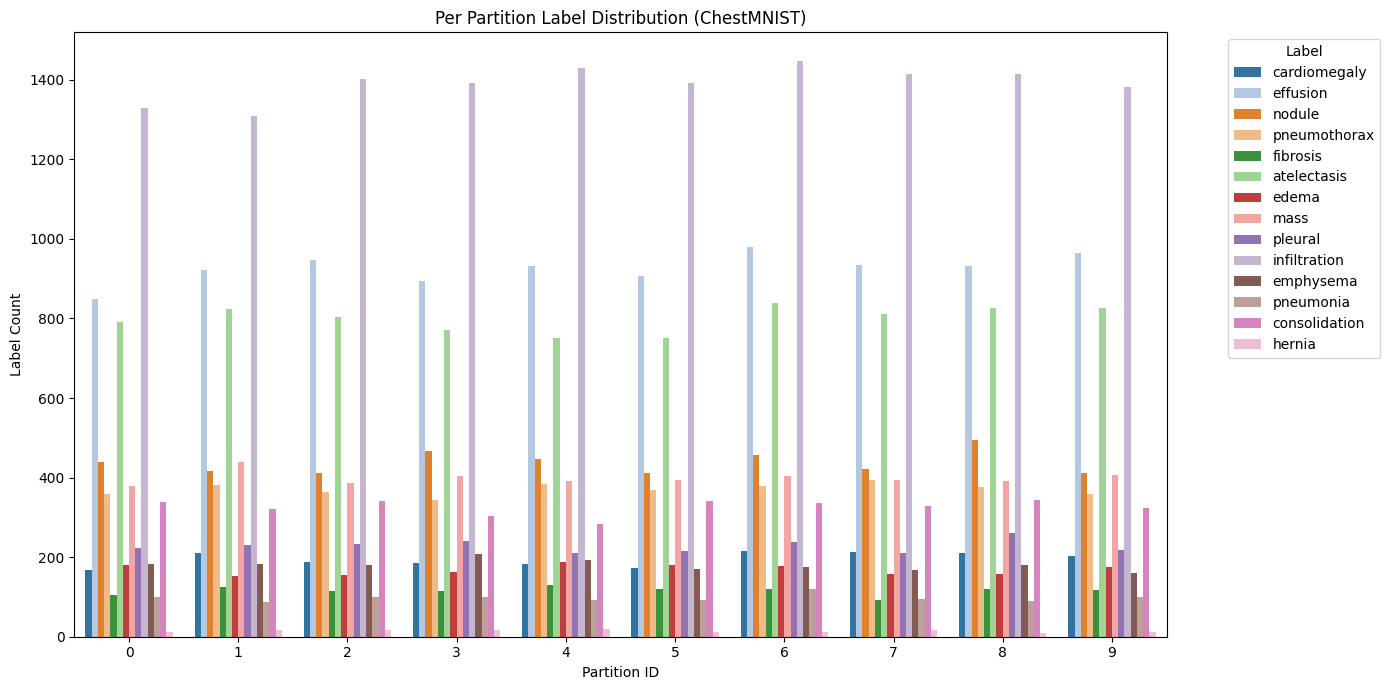

In [23]:
label_mapping = ['atelectasis', 'cardiomegaly', 'effusion', 'infiltration', 'mass',
                 'nodule', 'pneumonia', 'pneumothorax', 'consolidation', 'edema',
                 'emphysema', 'fibrosis', 'pleural', 'hernia']

label_data = []

for part_id, dataset in enumerate(fds):
    for _, label in dataset:
        if isinstance(label, np.ndarray):
            label = torch.tensor(label)
        label = label.int()
        for class_id, value in enumerate(label):
            if value == 1:
                label_data.append({"part_id": part_id, "label": label_mapping[class_id]})

df_labels = pd.DataFrame(label_data)

plt.figure(figsize=(14, 7))
sns.countplot(data=df_labels, x="part_id", hue="label", palette="tab20")
plt.title("Per Partition Label Distribution (ChestMNIST)")
plt.xlabel("Partition ID")
plt.ylabel("Label Count")
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

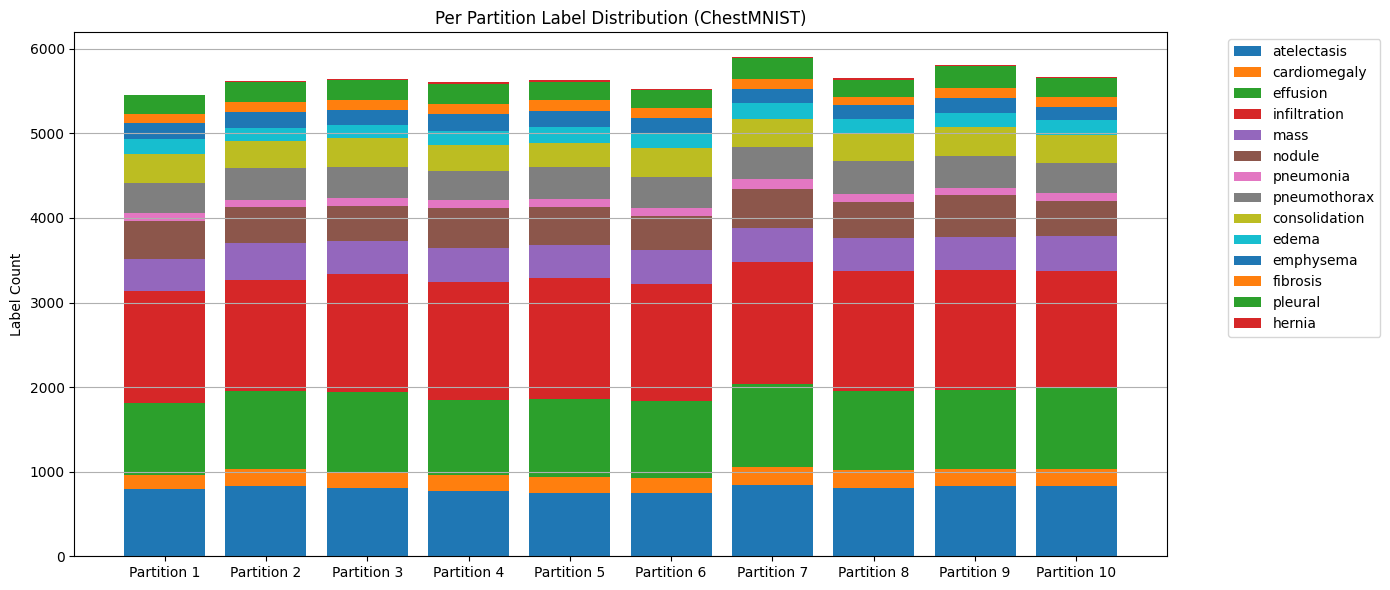

In [24]:
label_counts_per_part = []

for part_data in fds:
    labels_tensor = torch.stack([torch.tensor(item[1]) for item in part_data])  # (N, 14)
    label_sums = labels_tensor.sum(dim=0).tolist()
    label_counts_per_part.append(label_sums)

label_counts_per_client = np.array(label_counts_per_part)  # shape: (num_clients, num_labels)

# stacked bar chart
fig, ax = plt.subplots(figsize=(14, 6))
bottom = np.zeros(len(label_counts_per_client))

for i, label_name in enumerate(label_mapping):
    ax.bar(
        np.arange(len(label_counts_per_client)),
        label_counts_per_client[:, i],
        bottom=bottom,
        label=label_name
    )
    bottom += label_counts_per_client[:, i]

ax.set_xticks(np.arange(len(label_counts_per_client)))
ax.set_xticklabels([f'Partition {i+1}' for i in range(len(label_counts_per_client))])
ax.set_ylabel("Label Count")
ax.set_title("Per Partition Label Distribution (ChestMNIST)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


# Defining a Flower ClientApp

You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained collaboratively in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server running in a `ServerApp`.

A Flower Client is a simple Python class with two distinct methods:

  * `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server for aggregation.

  * `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. This can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be use to asses the degree of personalisation of the model being federated.

This class will be then wrapped into a ClientApp that can be used to launch the simulation.

Now let's define our Flower Client class:


In [25]:
from collections import OrderedDict
from typing import Dict, Tuple

import torch
from flwr.common import NDArrays, Scalar
from flwr.client import NumPyClient


class FlowerClient(NumPyClient):
    def __init__(self, trainloader, valloader) -> None:
        super().__init__()

        self.trainloader = train_loader
        self.valloader = val_loader
        self.model = create_model()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def fit(self, parameters, config):
        """This method trains the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        set_params(self.model, parameters)

        # Define the optimizer
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training (call same function as centralised setting)
        train(self.model, self.trainloader, optim, self.device)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return get_params(self.model), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        set_params(self.model, parameters)
        # do local evaluation (call same function as centralised setting)
        #loss, accuracy = test(self.model, self.valloader, self.device)
        loss, accuracy = test(self.model, self.valloader)
        
        
        # send statistics back to the server
        return float(loss), len(self.valloader), {"accuracy": accuracy}


# Two auxhiliary functions to set and extract parameters of a model
def set_params(model, parameters):
    """Replace model parameters with those passed as `parameters`."""

    params_dict = zip(model.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.from_numpy(v) for k, v in params_dict})
    # now replace the parameters
    model.load_state_dict(state_dict, strict=True)


def get_params(model):
    """Extract model parameters as a list of NumPy arrays."""
    return [val.cpu().numpy() for _, val in model.state_dict().items()]

x:\labs\AI4CI_DFL_MedMNIST Lab\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-23 16:00:34,981	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In Federated Learning, the way clients perform local training makes use of the same principles as more traditional centralised setup. The key difference is that the dataset now is much smaller and it's never "seen" by the entity running the FL workload (i.e. the central server).

## The `client_fn` callback

Now let's see how the `FlowerClient` object above can be used in Flower: we need to construct a `ClientApp`. This can be conveniently be done by means of a `client_fn` callback that will return a `FlowerClient` that uses a specific data partition (`partition-id`). The index of the partition is set internally during the simulation.

In [26]:
from flwr.common import Context
from flwr.client import ClientApp
from torch.utils.data import random_split, DataLoader

def client_fn(context: Context):
    """Return a FlowerClient with its own train/validation dataloaders."""

    partition_id = int(context.node_config["partition-id"])

    # Retrieve the client's dataset
    client_data = fds[partition_id]

    # split on train/val (90%/10%)
    val_size = int(len(client_data) * 0.1)
    train_size = len(client_data) - val_size
    train_subset, val_subset = random_split(client_data, [train_size, val_size], generator=torch.Generator().manual_seed(42))

    trainloader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
    valloader = DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

    return FlowerClient(trainloader=trainloader, valloader=valloader).to_client()


# Initialize the ClientApp
client_app = ClientApp(client_fn=client_fn)

Now that a ClientApp is fully defined, let's create its counterpart: the ServerApp.

# Defining a Flower `ServerApp`

## Chosing a Flower Strategy

A strategy sits at the core of the Federated Learning experiment. It is involved in all stages of a FL pipeline: sampling clients; sending the global model to the clients so they can do `fit()`; receive the updated models from the clients and **aggregate** these to construct a new global model; define and execute global or federated evaluation; and more.

Flower comes with [many strategies](https://github.com/adap/flower/tree/main/framework/py/flwr/server/strategy) built-in. For now, let's use what is arguable the most popular strategy out there: `FedAvg`.

`FedAvg`, as its name implies, derives a new version of the global model by taking the average of all the models sent by clients participating in the round. You can read all the details [in the paper](https://arxiv.org/abs/1602.05629).

In [27]:
from typing import List
from flwr.common import Metrics


# Define metric aggregation function
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}


# The `server_fn` callback

The easiest way to create a `ServerApp` with the aggregation strategy of your choice is by means of a `server_fn` callback. It has a similar signature to `client_fn` but, instead of returning a client object, it returns all the components needed to run the server-side logic in Flower.

In [28]:


from flwr.common import ndarrays_to_parameters
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg

num_rounds = 3


def server_fn(context: Context):

    # instantiate the model
    model = create_model()
    ndarrays = get_params(model)
    # Convert model parameters to flwr.common.Parameters
    global_model_init = ndarrays_to_parameters(ndarrays)

    # Define the strategy
    strategy = FedAvg(
        fraction_fit=0.1,  # 10% clients sampled each round to do fit()
        fraction_evaluate=0.5,  # 50% clients sample each round to do evaluate()
        evaluate_metrics_aggregation_fn=weighted_average,  # callback defined earlier
        initial_parameters=global_model_init,  # initialised global model
    )

    # Construct ServerConfig
    config = ServerConfig(num_rounds=num_rounds)

    # Wrap everything into a `ServerAppComponents` object
    return ServerAppComponents(strategy=strategy, config=config)


# Create your ServerApp
server_app = ServerApp(server_fn=server_fn)

# Launching the Simulation

With both `ClientApp` and `ServerApp` ready, we can launch the simulation. Pass both apps to the `run_simulation()` function and specify the number of **supernodes** (this is a more general term used in Flower to refer to individual "nodes" or "clients"). We earlier partitioned the dataset into 10 partitions, one for each supernode. So we indicate that `num_supernodes=10`.

In [29]:
from flwr.simulation import run_simulation

run_simulation(
    server_app=server_app, client_app=client_app, num_supernodes=NUM_PARTITIONS
)

INFO :      Starting Flower ServerApp, config: num_rounds=3, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 10)
Training: 100%|█████████▉| 2451/2453 [06:57<00:00,  5.98it/s] [repeated 60x across cluster]
                                                             
                                                             
INFO :      aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 5 clients (out of 10)
Evaluating:  49%|████▉     | 87/176 [00:34<00:18,  4.79it/s] [repeated 99x across cluster]
                                                             
                                                             
Evaluating:  98%|█████████▊| 173/176 [00:45<00:0